# Installing libraries and dependencies

In [ ]:
!python -m pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 16.3 MB/s eta 0:00:00


In [ ]:
import datetime
import shutil
import os
import glob
from pathlib import Path
from collections import Counter
from ultralytics import YOLO

import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Importing dataset into colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/gradproject/dataset/TDD-Net/archive.zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/pcb-defect-dataset/train/labels/rotation_270_light_09_mouse_bite_04_1_600.txt  
  inflating: /content/pcb-defect-dataset/train/labels/rotation_270_light_09_mouse_bite_04_2_600.txt  
  inflating: /content/pcb-defect-dataset/train/labels/rotation_270_light_09_mouse_bite_04_3_600.txt  
  inflating: /content/pcb-defect-dataset/train/labels/rotation_270_light_09_mouse_bite_04_4_600.txt  
  inflating: /content/pcb-defect-dataset/train/labels/rotation_270_light_09_mouse_bite_05_1_600.txt  
  inflating: /content/pcb-defect-dataset/train/labels/rotation_270_light_09_mouse_bite_05_2_600.txt  
  inflating: /content/pcb-defect-dataset/train/labels/rotation_270_light_09_mouse_bite_05_3_600.txt  
  inflating: /content/pcb-defect-dataset/train/labels/rotation_270_light_09_mouse_bite_05_4_600.txt  
  inflating: /content/pcb-defect-dataset/train/labels/rotation_270_light_09_mouse_bite_05_5_600.txt  
  inflating: /content/pcb-defec

# Creating k-fold split folders



---

Note: Creating dirs takes too much time on colab and doesn't require gpu so the splitting portion was done on PC then uploaded to drive

---



1. Collecting all label files in train and val folders of the dataset into an array

In [ ]:
dataset_path = Path('./pcb-defect-dataset')
sup_ext = ['.txt']

# Initialize an empty list to store image file paths
labels = []

# Loop through supported extensions and gather image files
for ext in sup_ext:
    labels.extend(sorted((dataset_path / 'train' / 'labels').rglob(f"*{ext}")))
    labels.extend(sorted((dataset_path / 'val' / 'labels').rglob(f"*{ext}")))

#labels = sorted(dataset_path.rglob("*labels/*.txt"))

2. Indexing classes based on the content of data.yaml (6 classes in our case labelled 0 to 5)

In [ ]:
with open('/content/pcb-defect-dataset/data.yaml', 'r', encoding="utf8") as y:
    classes = yaml.safe_load(y)['names']
cls_idx = list(range(len(classes)))

3. Organizing labels into a dataframe

*   index column: file name
*   column headers: index of classes (e.g. 0: missing hole, 1: mousebite etc)
*   column content: # class instances per file (e.g. 2.0 -> image 1, class 3: 2 defects in class 3 found in image 1)





In [ ]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`

In [ ]:
display(labels_df)

,0,1,2,3,4,5
l_light_01_missing_hole_01_1_600,0.0,0.0,1.0,0.0,0.0,0.0
l_light_01_missing_hole_01_2_600,0.0,0.0,2.0,0.0,0.0,0.0
l_light_01_missing_hole_02_1_600,0.0,0.0,2.0,0.0,0.0,0.0
l_light_01_missing_hole_02_2_600,0.0,0.0,1.0,0.0,0.0,0.0
l_light_01_missing_hole_02_3_600,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
rotation_90_light_12_spurious_copper_05_4_600,0.0,0.0,0.0,0.0,0.0,4.0
rotation_90_light_12_spurious_copper_06_1_600,0.0,0.0,0.0,0.0,0.0,1.0
rotation_90_light_12_spurious_copper_08_3_600,0.0,0.0,0.0,0.0,0.0,2.0
rotation_90_light_12_spurious_copper_08_4_600,0.0,0.0,0.0,0.0,0.0,3.0


4. Splitting dataset indices into 5 folds randomly

In [ ]:
ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results
kfolds = list(kf.split(labels_df))

5. Organizing dataset into train and val sets for each split into a dataframe

In [ ]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

6. Calculate ratio of class label distribution val:train

In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

7. Collect all image file in train and val folders in an array

In [ ]:
supported_extensions = ['.jpg', '.jpeg', '.png']

# Initialize an empty list to store image file paths
images = []

# Loop through supported extensions and gather image files
for ext in supported_extensions:
    images.extend(sorted((dataset_path / 'train' / 'images').rglob(f"*{ext}")))
    images.extend(sorted((dataset_path / 'val' / 'images').rglob(f"*{ext}")))

In [ ]:
display(len(images))

9600

8. Create k split directories and yaml files

In [ ]:
# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'/content/pcb-defect-dataset/2023-10-06_5-Fold_Cross-val')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)


9. Copy images from dataset to their respective places in each k split folder

In [ ]:
for image, label in zip(images, labels):
    print("inside loop 1")
    modified_stem = image.stem[:-3]
    matching_entries = folds_df[folds_df.index.str.startswith(modified_stem)].index[0]

    for split, k_split in folds_df.loc[matching_entries].items():
        print("inside loop 2")
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'
        display(img_to_path)
        print("\n")
        # Copy image and label files to new directory (SameFileError if file already exists)
        print(image)
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)
        print(f"Processed image {image} for split {split} and k_split {k_split}\n")


10. Save files distribution to csv

In [ ]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

11. Upload split datasets to drive (in case of training other models)

In [ ]:
!zip -r "content/drive/MyDrive/grad project/v8/TDD-Net/2023-10-06_5-Fold_Cross-val.zip" /content/pcb-defect-dataset/2023-10-06_5-Fold_Cross-val/

## Debugging:



```
#loop through image and label files
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Execute code
```


KeyError: 'light_01_missing_hole_01_600'

Can't find label in folds_df


1. Search for label in both images and labels


In [ ]:
temp_df = pd.DataFrame(images, columns=['path'])                                # Convert images array to a pandas Dataframe of image paths
temp_df['ImageName'] = temp_df['path'].apply(lambda x: os.path.basename(x))     # Extract image basenames from the paths
temp_df['ImageName'] = temp_df['ImageName'].str.rstrip('.jpg')                  # Remove .jpg extension to compare names
temp_df['Match'] = (temp_df['ImageName'] == folds_df.index)                     # Add Match column to compare file names in images and labels
display(temp_df)

,path
0,pcb-defect-dataset/train/images/l_light_01_mis...
1,pcb-defect-dataset/train/images/l_light_01_mis...
2,pcb-defect-dataset/train/images/l_light_01_mis...
3,pcb-defect-dataset/train/images/l_light_01_mis...
4,pcb-defect-dataset/train/images/l_light_01_mis...
...,...
9595,pcb-defect-dataset/val/images/rotation_90_ligh...
9596,pcb-defect-dataset/val/images/rotation_90_ligh...
9597,pcb-defect-dataset/val/images/rotation_90_ligh...
9598,pcb-defect-dataset/val/images/rotation_90_ligh...


2. compare file names similarity

In [ ]:
comp = pd.concat([temp_df['ImageName'], pd.DataFrame({'LabelName': folds_df.index}), temp_df['Match']], axis=1)   # Create new df to search for name mismatches
display(comp)

,ImageName,FoldIndex,Match
0,l_light_01_missing_hole_01_1_600,l_light_01_missing_hole_01_1_600,True
1,l_light_01_missing_hole_01_2_600,l_light_01_missing_hole_01_2_600,True
2,l_light_01_missing_hole_02_1_600,l_light_01_missing_hole_02_1_600,True
3,l_light_01_missing_hole_02_2_600,l_light_01_missing_hole_02_2_600,True
4,l_light_01_missing_hole_02_3_600,l_light_01_missing_hole_02_3_600,True
...,...,...,...
9595,rotation_90_light_12_spurious_copper_05_4_600,rotation_90_light_12_spurious_copper_05_4_600,True
9596,rotation_90_light_12_spurious_copper_06_1_600,rotation_90_light_12_spurious_copper_06_1_600,True
9597,rotation_90_light_12_spurious_copper_08_3_600,rotation_90_light_12_spurious_copper_08_3_600,True
9598,rotation_90_light_12_spurious_copper_08_4_600,rotation_90_light_12_spurious_copper_08_4_600,True




---


~ Debugging results:

*   Some images in images folder end in [image_name]_600 whose labels are [image_name]_256
*   training yolov8 without cv didn't result in an error bec yolo algorithm can handle different label names

~ Solution approaches:

*   Modify file names
*   Modify splitting images code to handle different labels

---









In [ ]:
x1 = images[0]        # mock variable to loop through image names
x2 = folds_df[folds_df.index.str.startswith(x1.stem[:-3])].index[0]   # look for entries that start with the same file name excluding the last three digits
print(x2)

l_light_01_missing_hole_01_1_600




---


~ Chosen approach: Modify splitting algorithm

1.   x1.stem -> extracts image name from path
2.   [:-3] -> excludes the last three chars from the image name
3.   .str.startswith() -> matches the entry whose string starts with exactly the image name
4.   folds_df.index -> gets the index of the element (output of match)
5.   folds_df[] -> outputs the entry that has the index of folds_df.index
6.   .index[0] -> gets the content of the index column of the matching entry since the match output can only be ONE entry


---





# Switching to previously prepared kfold

1. Upload previously prepared dataset
>   Change file path according to your drive since some changes made by file authors are sometimes not visible


In [ ]:
!file "/content/drive/MyDrive/gradproject/v8/TDD-Net/tddcvdataset.zip"

/content/drive/MyDrive/gradproject/v8/TDD-Net/tddcvdataset.zip: Zip archive data, at least v2.0 to extract, compression method=deflate


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/gradproject/v8/TDD-Net/tddcvdataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

2. Remove directories made through previous steps if any

In [ ]:
pwd

'/content'

In [ ]:
cd ../../../content

/content


In [ ]:
shutil.rmtree("./pcb-defect-dataset/2023-11-02_5-Fold_Cross-val")

3. Add new dataset directory to dataset path

In [ ]:
Path("/content/pcb-defect-dataset/2023-10-06_5-Fold_Cross-val").mkdir(parents=True, exist_ok=True)

In [ ]:
source_folder = r"/content/2023-10-06_5-Fold_Cross-val/"
destination_folder = r"/content/pcb-defect-dataset/2023-10-06_5-Fold_Cross-val/"

my_subdirs = [os.path.join(source_folder, o) for o in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, o))]
for subdir in my_subdirs:
    shutil.move(subdir, destination_folder)

# Train YOLO model using kfold splits

## Changing required yaml files



---

Uploaded dataset has paths set to working directories on PC -- change them to current env dir

1. Show uploaded yaml files content

In [ ]:
with open('/content/pcb-defect-dataset/2023-10-06_5-Fold_Cross-val/split_2/split_2_dataset.yaml', 'r') as f:
  data = yaml.safe_load(f)
display(data)

{'names': {0: 'mouse_bite',
  1: 'spur',
  2: 'missing_hole',
  3: 'short',
  4: 'open_circuit',
  5: 'spurious_copper'},
 'path': 'E:/final-grad-project/v8_attempt/kfold-cv/pcb-defect-dataset/2023-10-06_5-Fold_Cross-val/split_2',
 'train': 'train',
 'val': 'val'}

2. Change each yaml file content

In [ ]:
save_path = Path(dataset_path / f'/content/pcb-defect-dataset/2023-10-06_5-Fold_Cross-val')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)




---

yolov8 default settings looks for dataset inside "content/datasets" so we're changing it to "content/"

In [ ]:
with open('/root/.config/Ultralytics/settings.yaml', 'r') as f:
  settings = yaml.safe_load(f)
display(settings)

{'settings_version': '0.0.4',
 'datasets_dir': '/content/datasets',
 'weights_dir': 'weights',
 'runs_dir': 'runs',
 'uuid': '569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb',
 'sync': True,
 'api_key': '',
 'clearml': True,
 'comet': True,
 'dvc': True,
 'hub': True,
 'mlflow': True,
 'neptune': True,
 'raytune': True,
 'tensorboard': True,
 'wandb': True}

In [ ]:
cd ../root/.config/Ultralytics/

/root/.config/Ultralytics


In [ ]:
ls -a

./  ../  settings.yaml


In [ ]:
settings = [{'settings_version': '0.0.4',
            'datasets_dir': '/content',
            'weights_dir': 'weights',
            'runs_dir': 'runs',
            'uuid': '569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb',
            'sync': True,
            'api_key': '',
            'clearml': True,
            'comet': True,
            'dvc': True,
            'hub': True,
            'mlflow': True,
            'neptune': True,
            'raytune': True,
            'tensorboard': True,
            'wandb': True}]
with open('settings.yaml', 'w') as yaml_file:
    yaml.dump_all(settings, yaml_file, sort_keys=False, default_flow_style=False)



> Note:
>
> Modifing dictionary key values as in `settings['datasets_dir'] = '/content'` results in splitting the yaml file into multiple documents, which is to say each dictionary key becomes a document on its own with the yaml file acting as a parent dir.
>
> The impact of this on model training wasn't tested but to prevent any possible negative outcome, it was chosen to dump all dictionary content at once.



In [ ]:
with open('/root/.config/Ultralytics/settings.yaml', 'r') as f:
    settings = yaml.safe_load(f)
display(settings)

{'settings_version': '0.0.4',
 'datasets_dir': '/content',
 'weights_dir': 'weights',
 'runs_dir': 'runs',
 'uuid': '569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb',
 'sync': True,
 'api_key': '',
 'clearml': True,
 'comet': True,
 'dvc': True,
 'hub': True,
 'mlflow': True,
 'neptune': True,
 'raytune': True,
 'tensorboard': True,
 'wandb': True}

In [ ]:
cd ../../../content/

/content


## Train the model

1. Train the model for ksplit

In [ ]:
model = YOLO("yolov8s.pt", task='detect')
results = {}

batch = 16
epochs = 50
imgsz = 416

for k in range(ksplit):
  dataset_yaml = ds_yamls[k]
  model.train(data=dataset_yaml, epochs=epochs, batch=batch, imgsz=imgsz, project='v8-kfold-cv')
  results[k] = model.metrics



---

Note: Due to Colab's limited GPU capacities, the training was done for each split individually

---



In [ ]:
model = YOLO("yolov8s.pt", task='detect')
results = {}

batch = 16
epochs = 50
imgsz = 416

k = 2
dataset_yaml = ds_yamls[k]
model.train(data=dataset_yaml, epochs=epochs, batch=batch, imgsz=imgsz, project='v8-kfold-cv')
results[k] = model.metrics

100%|██████████| 21.5M/21.5M [00:00<00:00, 186MB/s]
Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/pcb-defect-dataset/2023-10-06_5-Fold_Cross-val/split_3/split_3_dataset.yaml, epochs=50, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=v8-kfold-cv, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, a

2. Saving run results

In [ ]:
with open("results_2.txt", "w") as output:
    output.write(str(results[k]))

### Saving results



---

Viewing folder size

Problems:
1. `!zip` -> can't recognize file formats
2. `shutil.make_archive()` -> <br>a. takes too much time running <br>b. produces corrupt files<br>c. exceeds disk size



---



1. Checking folder size

In [ ]:
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size

folder_path = '/content/v8-3fold-cv'
folder_size_bytes = get_folder_size(folder_path)

# Convert the size to a string
def convert_bytes(size_in_bytes):
    size_in_bytes = float(size_in_bytes)
    if size_in_bytes == 0:
        return "0 B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = 0
    while size_in_bytes >= 1024 and i < len(size_name) - 1:
        size_in_bytes /= 1024
        i += 1
    return f"{round(size_in_bytes, 2)} {size_name[i]}"

folder_size = convert_bytes(folder_size_bytes)
print(f"Size of the folder '{folder_path}': {folder_size}")

Size of the folder '/content/v8-4fold-cv': 54.36 MB


2. zipping folder

In [ ]:
def zip_directory(directory_path, output_zip_path):
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, directory_path)
                zipf.write(file_path, arcname=arcname)

# Define the paths for your directory and the output ZIP file
directory_to_zip = "/content/v8-3fold-cv"
output_zip_file = "/content/v8-3fold-cv.zip"

# Call the function to create the ZIP archive
zip_directory(directory_to_zip, output_zip_file)

In [ ]:
shutil.copy("/content/v8-3fold-cv.zip", "/content/drive/MyDrive/gradproject/v8/")

'/content/drive/MyDrive/gradproject/v8/v8-3fold-cv.zip'

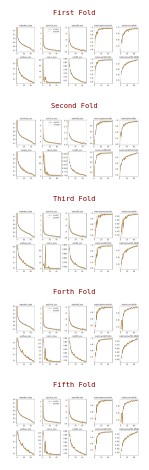

In [ ]:
fig, axes = plt.subplots(5, 1)

image1 = cv2.imread('results_1fold.png')
image2 = cv2.imread('results_2fold.png')
image3 = cv2.imread('results_3fold.png')
image4 = cv2.imread('results_4fold.png')
image5 = cv2.imread('results_5fold.png')


axes[0].imshow(image1)
axes[1].imshow(image2)
axes[2].imshow(image3)
axes[3].imshow(image4)
axes[4].imshow(image5TT)

title_font = {'family': 'monospace', 'color':  'darkred', 'weight': 'normal', 'size': 5}
axes[0].set_title('First Fold', fontdict=title_font)
axes[1].set_title('Second Fold', fontdict=title_font)
axes[2].set_title('Third Fold', fontdict=title_font)
axes[3].set_title('Forth Fold', fontdict=title_font)
axes[4].set_title('Fifth Fold', fontdict=title_font)

# Remove axis labels
for ax in axes.flat:
    ax.axis('off')

# Adjust subplot layout to prevent overlapping
plt.tight_layout()

# Show the grid of images
plt.show()
